In [1]:
from huggingface_hub import login
from esm.models.esm3 import ESM3
from esm.sdk.api import ESM3InferenceClient, ESMProtein, GenerationConfig
from protein_interpretability.extractor import ESM3ActivationExtractor
from dotenv import load_dotenv
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch


In [ ]:
model: ESM3InferenceClient = ESM3.from_pretrained("esm3-open").to("cuda") # or "cpu"

# Generate a completion for a partial Carbonic Anhydrase (2vvb)
prompt = "___________________________________________________DQATSLRILNNGHAFNVEFDDSQDKAVLKGGPLDGTYRLIQFHFHWGSLDGQGSEHTVDKKKYAAELHLVHWNTKYGDFGKAVQQPDGLAVLGIFLKVGSAKPGLQKVVDVLDSIKTKGKSADFTNFDPRGLLPESLDYWTYPGSLTTPP___________________________________________________________"
protein = ESMProtein(sequence=prompt)

extractor = ESM3ActivationExtractor(
    model,
    sites=None,              # all: encoder, transformer_out, transformer_embed, output_heads_in
    layers=None,             # all transformer blocks
    layer_sites=["block", "attn", "geom_attn", "ffn"],  # default is only ["block"]
    detach=True,
)
with extractor.recording():
    protein = model.generate(protein, GenerationConfig(track="sequence", num_steps=2, temperature=0.7))


100%|██████████| 2/2 [00:00<00:00, 15.93it/s]


In [ ]:
import torch
import numpy as np

def sort_layer_activations(layer_tensor: torch.Tensor) -> tuple[np.ndarray, np.ndarray]:
    """
    For one layer activation tensor (B, L, D), compute mean |act| per node and sort by most active.
    Returns:
        act_sorted: (D,) activity values in descending order
        top_indices: (D,) node indices that achieve that order
    """
    node_activity = layer_tensor.abs().squeeze().mean(dim=0).float().cpu().numpy()  # (D,)
    top_indices = np.argsort(-node_activity)
    act_sorted = node_activity[top_indices]
    return act_sorted, top_indices


(array([3.480000e+02, 2.962500e+01, 7.625000e+00, ..., 6.982422e-02,
        6.591797e-02, 6.542969e-02], shape=(1536,), dtype=float32),
 array([1361,  805,  881, ..., 1224,  362,  709], shape=(1536,)))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors


def plot_all_layers_sorted(
    activations: dict[str, torch.Tensor],
    layer_keys: list[str] | None = None,
):
    """
    If layer_keys is None:
        Plot ALL keys that match "layer_{i}_{something}".
    Otherwise:
        Plot only the specified keys.
    """

    # ---- auto-detect all layer_*_* keys
    if layer_keys is None:
        layer_keys = sorted(
            [k for k in activations if k.startswith("layer_")],
            key=lambda k: int(k.split("_")[1]),
        )

    acts_sorted = []
    for k in layer_keys:
        act_sorted, _ = sort_layer_activations(activations[k])
        acts_sorted.append(act_sorted)

    matrix = np.array(acts_sorted)[::-1]
    layer_labels = layer_keys[::-1]

    fig, ax = plt.subplots(figsize=(12, 10))

    vmin = max(matrix.min(), 1e-12)
    vmax = matrix.max()

    sns.heatmap(
        matrix,
        ax=ax,
        norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),
        cbar_kws={"label": "mean |act| (sorted)"},
        xticklabels=False,
        yticklabels=layer_labels,
    )

    ax.set_xlabel("Node rank (most → least active)")
    ax.set_ylabel("Layer")
    plt.tight_layout()

    return fig, ax

(<Figure size 1200x1000 with 2 Axes>,
 <Axes: xlabel='Node rank (most → least active)', ylabel='Layer'>)

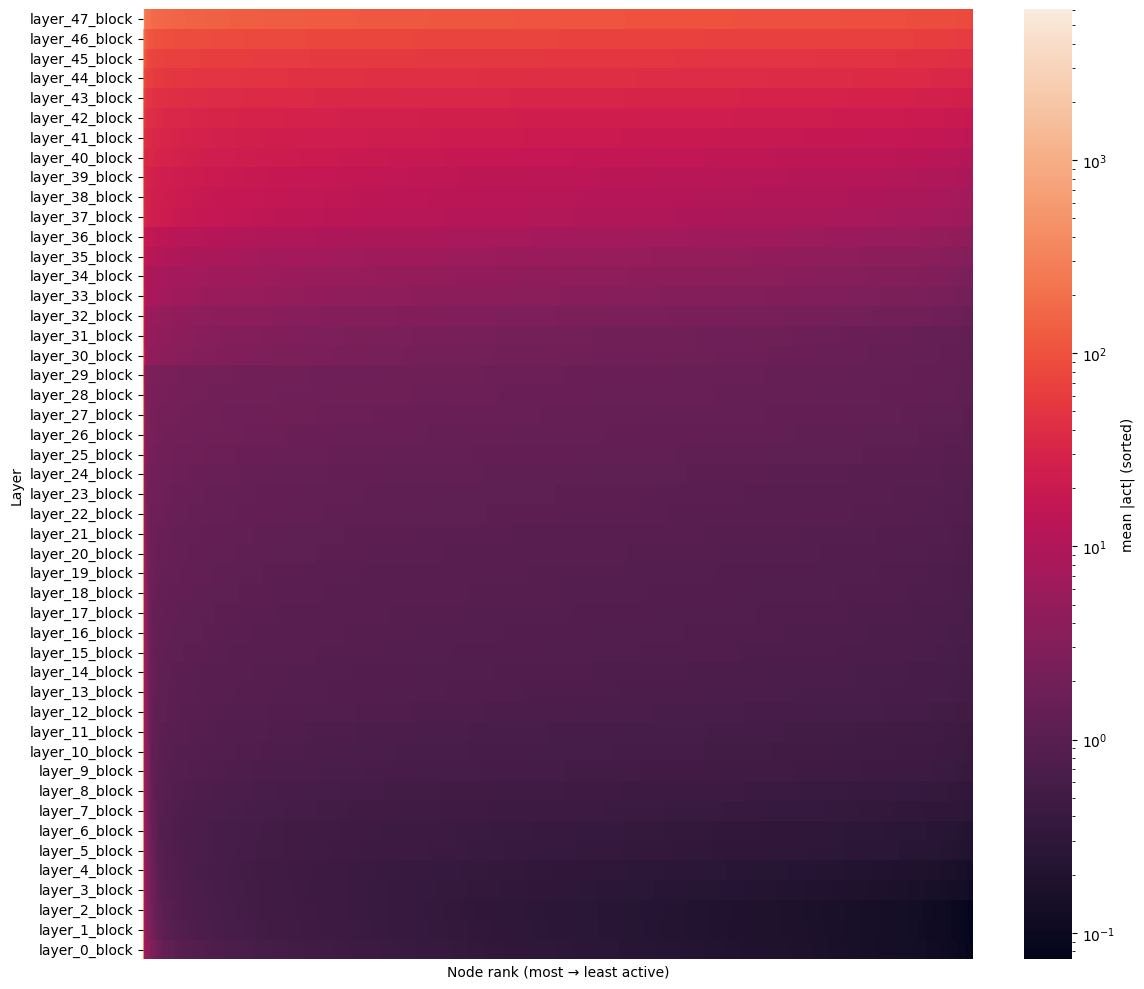

In [29]:
step0 = extractor.get_step(0)
# act_sorted, top_idx = sort_layer_activations(step0["layer_0_block"])
plot_all_layers_sorted(step0)